# **Ejemplo 3: Bitcoin**

In [4]:
library('dplyr')
library('tidyr')
library('ggplot2')
#install.packages('diagram')
library('diagram')

In [55]:
# Función para calcular la potencia de una matriz
mmult <- function(m, n){
  # inputs:
  #   m : matriz 
  #   n : potencia
  # outputs:
  #   Mn : matriz potencia n
  for(i in 1:n){
    if(i == 1){
      Mn <- m
    }else{
      Mn <- Mn%*%m
    }
  }
  return(Mn)
}

In [56]:
# Función para generar trajectorias de una Cadena de Markov
sim.MarkovChain <- function(P, d, n=100){
  # Inputs:
  #   P  : Matriz de transición.
  #   d  : Distribución inicial. 
  #   n  : Número de trajectorias.

  n.states <- ncol(P)     # número de estados
  Xn <- numeric(n)        # inicialización de vector de tamaño n para almacenar la trajectoria
  Xn[1] <- sample(n.states, 1, replace=TRUE, prob=d)  # generación de un estado al azar con probavilidad d
  # inicia bucle for
  for(i in 2:(n)){
    # inicia con estado inicial generado anteriormente Xn[1]
    ini.state <- Xn[i-1]  
    # selecciona un estado al azar con probabilidad dada por el estado inicial
    Xn[i] <- sample(n.states, 1, replace=TRUE, prob=P[ini.state, ]) 
  }
  return(Xn-1)
}

In [61]:
btc <- read.csv('BTC-USD.csv') 
head(btc)

,Date,Open,High,Low,Close,Adj.Close,Volume
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-01-01,28994.01,29600.63,28803.59,29374.15,29374.15,40730301359
2,2021-01-02,29376.46,33155.12,29091.18,32127.27,32127.27,67865420765
3,2021-01-03,32129.41,34608.56,32052.32,32782.02,32782.02,78665235202
4,2021-01-04,32810.95,33440.22,28722.76,31971.91,31971.91,81163475344
5,2021-01-05,31977.04,34437.59,30221.19,33992.43,33992.43,67547324782
6,2021-01-06,34013.61,36879.70,33514.04,36824.36,36824.36,75289433811


In [29]:
(32127.27-29374.15)/29374.15


[1] 0.09372595

## Rendimiento simple

$$ r_t =  \frac{P_t - P_{t-1}}{P_{t-1}}$$

In [37]:
# Función para calcular rendimiento simple
getReturns <- function(x){
  # input:
  #   x : Data frame primer columna Date, y segunda columna precio.
  # Output :
  #   data.frame : Data frame primer columna Date, y segunda columna rendimientos
  date <- x$Date
  ret <- numeric(nrow(x))
  for(i in 2:nrow(x)){
     ret[i] <- (x$Close[i] - x$Close[i-1])/x$Close[i-1]
  }
  result <- data.frame('Date'=date[-1], 'Rendimiento'= ret[-1])
  return(result)
}


In [38]:
btc2 <- btc %>% 
  select(Date, Close) %>%
  getReturns()
head(btc2)

,Date,Rendimiento
,<chr>,<dbl>
1,2021-01-02,0.09372578
2,2021-01-03,0.02038007
3,2021-01-04,-0.02471200
4,2021-01-05,0.06319658
5,2021-01-06,0.08331071
6,2021-01-07,0.06915747


# Clasificación de los rendimientos

- Up   : Si Rendimiento > 0
- Down : Si Rendimiento < 0
- None : Si Rendimiento = 0


In [49]:
# Clasificación de los rendimients

btc3 <- btc2 %>%
  mutate('clase' = ifelse(Rendimiento > 0.02, 'Up', 
                      ifelse(Rendimiento < -0.02, 'Down', 'None')))
head(btc3)

,Date,Rendimiento,clase
,<chr>,<dbl>,<chr>
1,2021-01-02,0.09372578,Up
2,2021-01-03,0.02038007,Up
3,2021-01-04,-0.02471200,Down
4,2021-01-05,0.06319658,Up
5,2021-01-06,0.08331071,Up
6,2021-01-07,0.06915747,Up


In [50]:
P <- embed(btc3$clase, 2)[, 2:1] %>%
  data.frame() %>%
  rename(current=X1, next_day=X2) %>%
  group_by(current, next_day) %>%
  summarise('n'=n()) %>%
  mutate('total'=sum(n),
          'prop' = round(n/total, 2)) %>%
  arrange(current) %>%
  select(-n, -total) %>%
  pivot_wider(names_from='next_day', values_from='prop')%>%
  ungroup() %>%
  data.frame()

# elimina columna current
row.names(P) <- P[,1]
P <- as.matrix(P[,-1])
head(P)

`summarise()` has grouped output by 'current'. You can override using the
`.groups` argument.


,Down,None,Up
Down,0.23,0.45,0.32
None,0.34,0.39,0.27
Up,0.20,0.47,0.33


In [51]:
rowSums(P)

Down None   Up 
   1    1    1

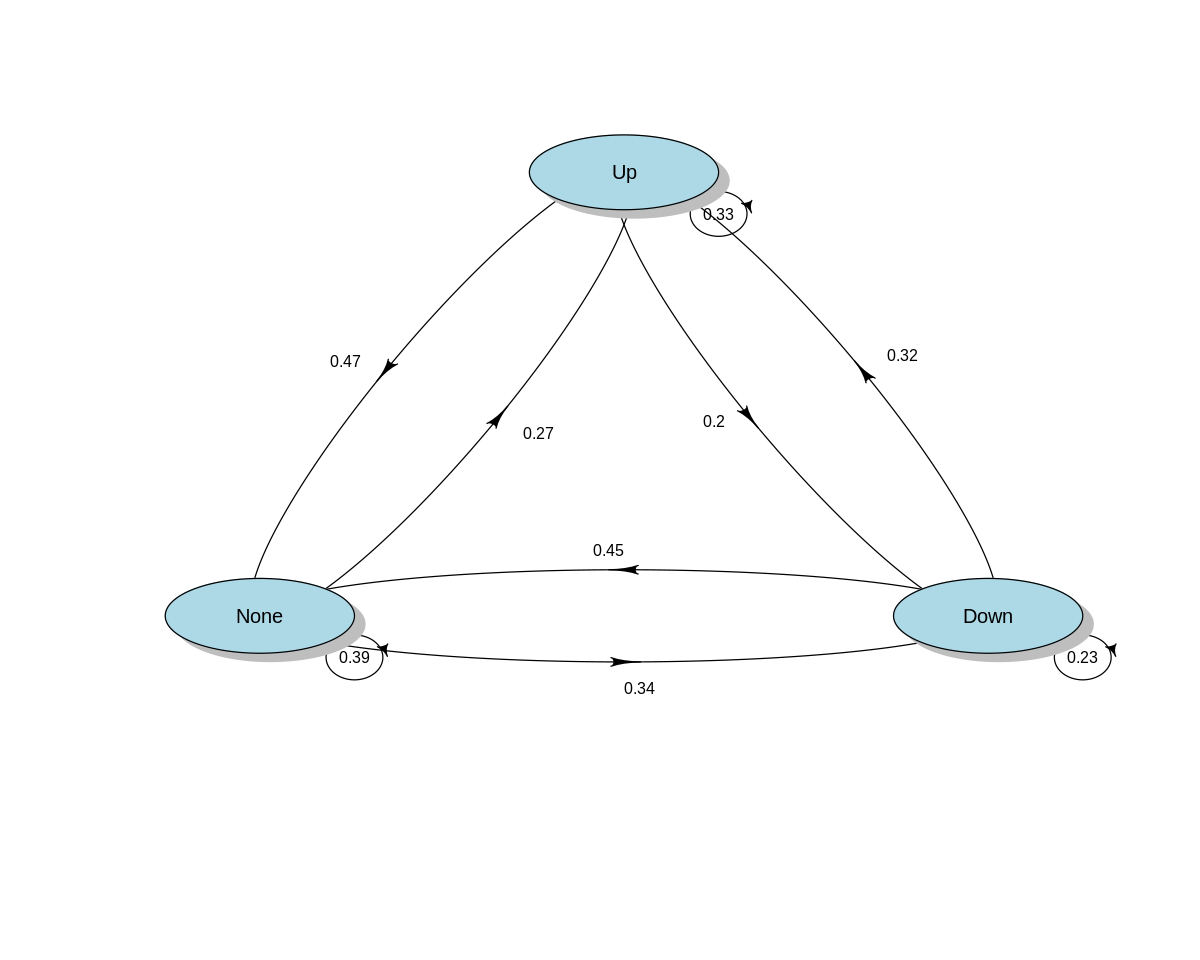

In [53]:
# Diagrama de transiciones
options(repr.plot.width=10, repr.plot.height=8)
plotmat(t(P),name=c("Down","None", "Up"),
arr.length=0.3,arr.width=0.1,box.col="lightblue",box.lwd=1,box.prop=0.5,box.size=0.09,
box.type="circle",cex.txt=0.8,lwd=1,self.cex=0.3,
self.arrpos=0.3,self.shiftx=0.09,self.shifty=-0.05)

# Probabilidades de transición de n pasos

In [58]:
n.max = 20
for(i in 1:n.max){
    Pn <- mmult(P, n=i)
    cat(paste('Matriz de probabilidades de transición de n= ', i, ' pasos \n', sep=''))
    print(Pn)
}

Matriz de probabilidades de transición de n= 1 pasos 
     Down None   Up
Down 0.23 0.45 0.32
None 0.34 0.39 0.27
Up   0.20 0.47 0.33
Matriz de probabilidades de transición de n= 2 pasos 
       Down   None     Up
Down 0.2699 0.4294 0.3007
None 0.2648 0.4320 0.3032
Up   0.2718 0.4284 0.2998
Matriz de probabilidades de transición de n= 3 pasos 
         Down     None       Up
Down 0.268213 0.430250 0.301537
None 0.268424 0.430144 0.301432
Up   0.268130 0.430292 0.301578
Matriz de probabilidades de transición de n= 4 pasos 
          Down      None        Up
Down 0.2682814 0.4302157 0.3015029
None 0.2682729 0.4302200 0.3015071
Up   0.2682848 0.4302140 0.3015012
Matriz de probabilidades de transición de n= 5 pasos 
          Down      None        Up
Down 0.2682786 0.4302171 0.3015042
None 0.2682790 0.4302169 0.3015041
Up   0.2682785 0.4302172 0.3015043
Matriz de probabilidades de transición de n= 6 pasos 
          Down      None        Up
Down 0.2682788 0.4302171 0.3015042
None 0.2682787

# Distribución a n pasos


\begin{equation}
\pi^n  = \pi^{n-1} \textbf{P}  = \pi^0 \textbf{P}^{(n)} 
\end{equation}

In [59]:
head(Pn)

,Down,None,Up
Down,0.2682788,0.4302171,0.3015042
None,0.2682788,0.4302171,0.3015042
Up,0.2682788,0.4302171,0.3015042


In [62]:
# Observamos el último día
tail(btc3)

,Date,Rendimiento,clase
,<chr>,<dbl>,<chr>
359,2021-12-26,0.007528402,None
360,2021-12-27,-0.003328071,None
361,2021-12-28,-0.060259426,Down
362,2021-12-29,-0.024042279,Down
363,2021-12-30,0.015791121,None
364,2021-12-31,-0.018476353,None


In [63]:
# distribución inicial
di <- c(0, 1, 0)  #  Suponiendo que en 2021-12-31 se considera None

# distribución a n pasos
n <- 1000
Dn <- matrix(0, ncol=ncol(P), nrow=n)

for(i in 1:n){
    Dn[i,] <- di%*%mmult(P, n=i)
    cat(paste('Distribución a n= ', i, ' pasos \n', sep=''))
    print(di%*%mmult(P, n=i))
}

Distribución a n= 1 pasos 
     Down None   Up
[1,] 0.34 0.39 0.27
Distribución a n= 2 pasos 
       Down  None     Up
[1,] 0.2648 0.432 0.3032
Distribución a n= 3 pasos 
         Down     None       Up
[1,] 0.268424 0.430144 0.301432
Distribución a n= 4 pasos 
          Down    None        Up
[1,] 0.2682729 0.43022 0.3015071
Distribución a n= 5 pasos 
         Down      None        Up
[1,] 0.268279 0.4302169 0.3015041
Distribución a n= 6 pasos 
          Down      None        Up
[1,] 0.2682787 0.4302171 0.3015042
Distribución a n= 7 pasos 
          Down      None        Up
[1,] 0.2682788 0.4302171 0.3015042
Distribución a n= 8 pasos 
          Down      None        Up
[1,] 0.2682788 0.4302171 0.3015042
Distribución a n= 9 pasos 
          Down      None        Up
[1,] 0.2682788 0.4302171 0.3015042
Distribución a n= 10 pasos 
          Down      None        Up
[1,] 0.2682788 0.4302171 0.3015042
Distribución a n= 11 pasos 
          Down      None        Up
[1,] 0.2682788 0.4302171 0.3

In [68]:
df <- data.frame('n'=1:n, Dn)
colnames(df) <- c('n', 'Down', 'None', 'Up')
head(df)

,n,Down,None,Up
,<int>,<dbl>,<dbl>,<dbl>
1,1,0.3400000,0.3900000,0.2700000
2,2,0.2648000,0.4320000,0.3032000
3,3,0.2684240,0.4301440,0.3014320
4,4,0.2682729,0.4302200,0.3015071
5,5,0.2682790,0.4302169,0.3015041
6,6,0.2682787,0.4302171,0.3015042


In [69]:
df <- df %>% 
  pivot_longer(!n, names_to='State', values_to='Probability')
head(df)

n,State,Probability
<int>,<chr>,<dbl>
1,Down,0.3400
1,None,0.3900
1,Up,0.2700
2,Down,0.2648
2,None,0.4320
2,Up,0.3032


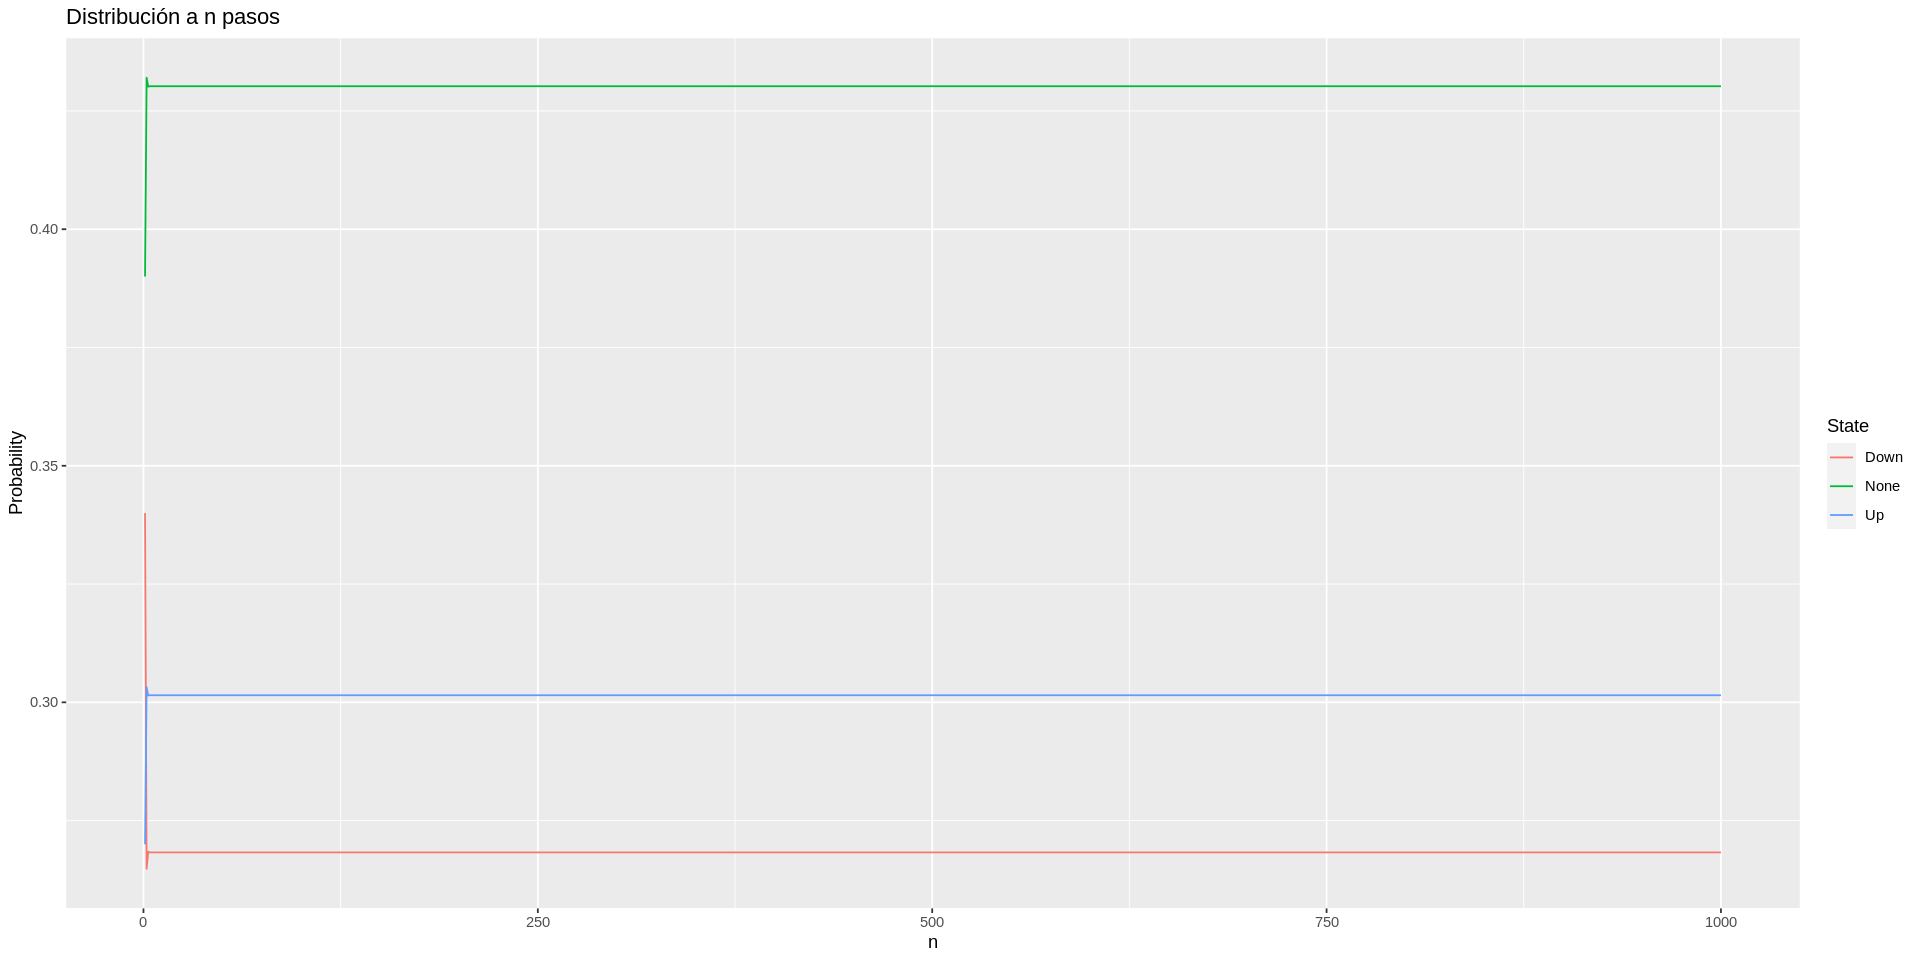

In [70]:
options(repr.plot.width=16, repr.plot.height=8)
p1 <- ggplot(df, aes(x=n, y=Probability, color=State)) +
  ggtitle('Distribución a n pasos') +
  geom_line()
p1

# Simulación de múltiples trajectorias

In [73]:
# # número de pasos a generar
n = 100
# número de trajectorias
m = 20
# distribución inicial
d <- c(0, 1, 0)
# matriz de probabilidades de transición
P 

,Down,None,Up
Down,0.23,0.45,0.32
None,0.34,0.39,0.27
Up,0.20,0.47,0.33


In [74]:
# simulación de m trajectorias con n pasos
mat.sim <- matrix(0, ncol=n, nrow=m)
for(i in 1:m){
  mat.sim[i,] <- sim.MarkovChain(P, d, n)
}
# data.frame
df_mat_sim <- data.frame('m'= 1:m, mat.sim)
# colnames
colnames(df_mat_sim) <- c('m', sapply(1:n, function(i) paste('S_',i, sep='')))
head(df_mat_sim)

,m,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,⋯,S_91,S_92,S_93,S_94,S_95,S_96,S_97,S_98,S_99,S_100
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2,1,0,1,1,1,0,0,⋯,1,2,2,1,1,0,1,0,0,2
2,2,1,0,1,2,1,2,2,2,1,⋯,1,1,2,1,2,1,0,1,1,1
3,3,1,1,0,2,1,1,1,0,0,⋯,1,1,2,0,0,1,1,1,0,1
4,4,1,2,1,2,2,1,2,2,0,⋯,1,0,2,1,1,0,1,1,0,2
5,5,1,0,0,1,1,1,0,1,0,⋯,1,0,1,1,1,2,1,0,2,1
6,6,1,2,1,1,1,0,2,2,0,⋯,0,1,1,1,2,1,1,1,1,1


In [75]:
df_final <- df_mat_sim %>%
  pivot_longer(!m, names_to='Step', values_to='value') %>%
  mutate(Step = as.numeric(substring(Step,3,10))) %>%
  mutate(m = as.character(m))
 head(df_final) 

m,Step,value
<chr>,<dbl>,<dbl>
1,1,1
1,2,2
1,3,1
1,4,0
1,5,1
1,6,1


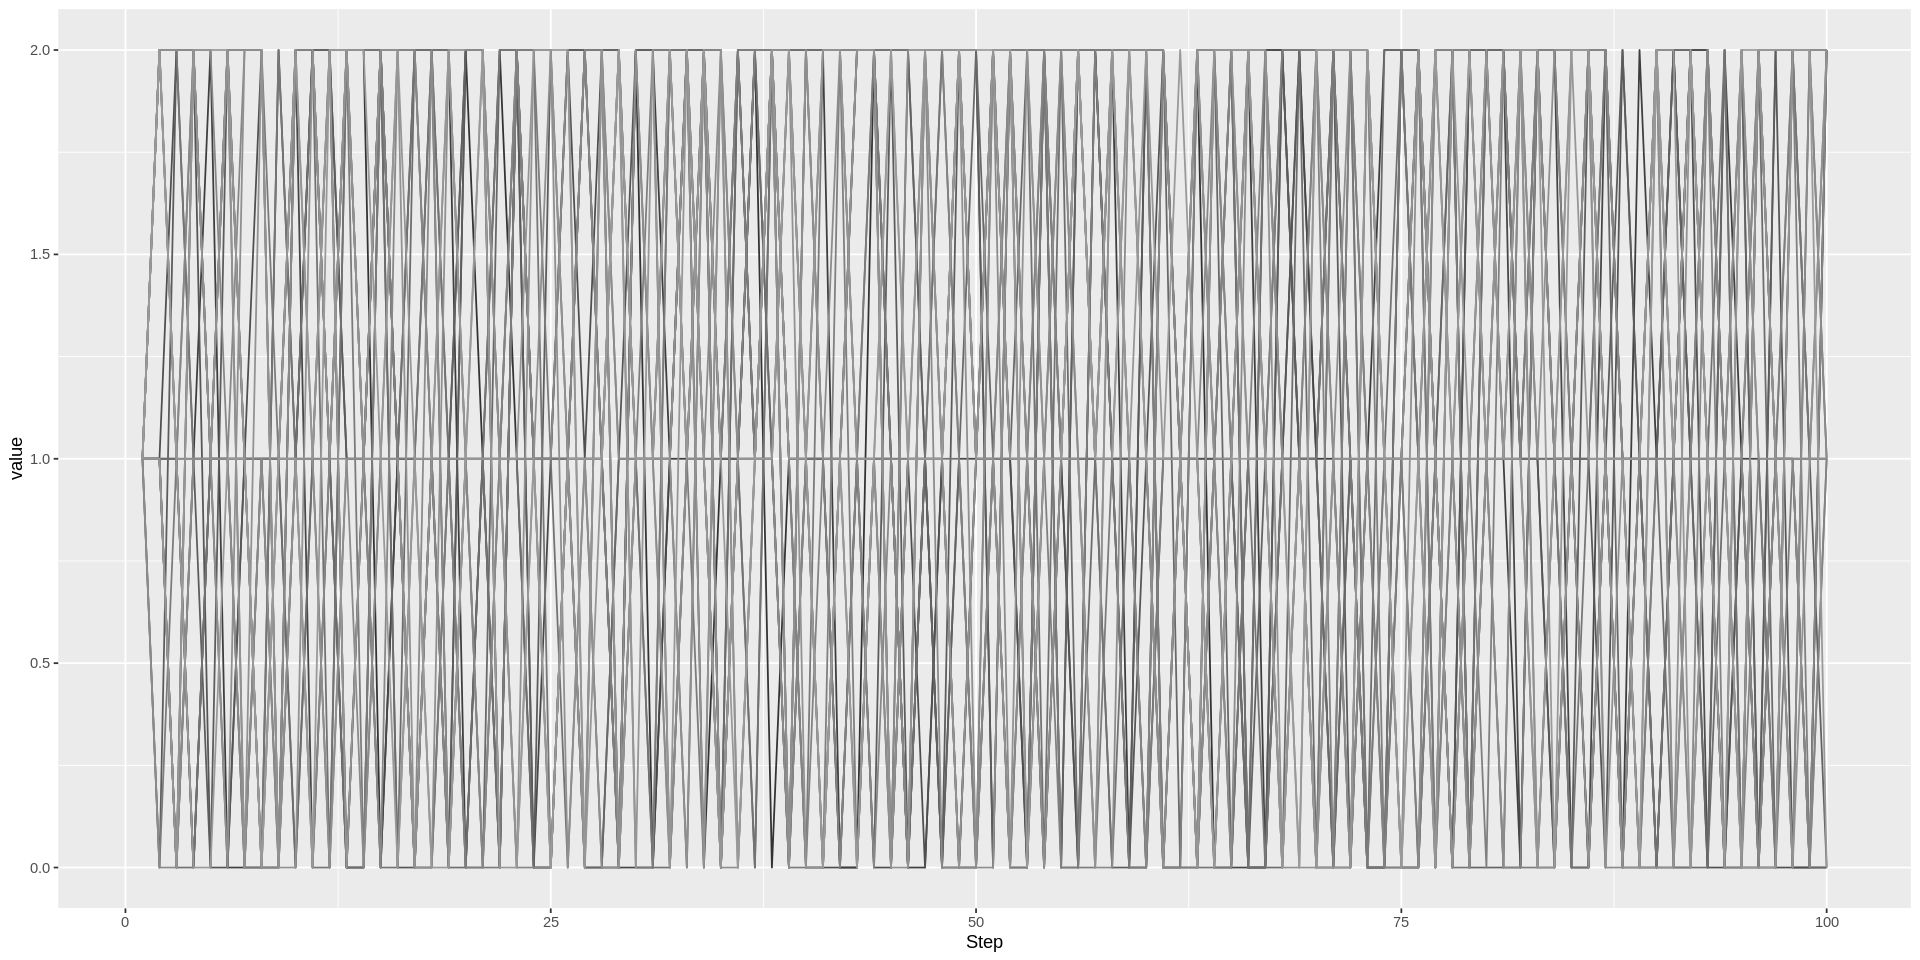

In [76]:
# gráfico de múltiples trayectorias
p5 <- ggplot(df_final, aes(x=Step, y=value, color=m)) +
  geom_line() +
  scale_colour_grey(start = 0.2,end = 0.6) +
  theme(legend.position="none") 
  
p5

# Teorema ergódico

In [81]:
# número de pasos a generar
n = 5000
# distribución inicial
d <- list('state0'=c(1, 0, 0),
          'state1'=c(0, 1, 0),
          'state2'=c(0, 0, 1))
# nombre de estado          
names <- names(d)
# matriz de probabilidades de transición
P 

,Down,None,Up
Down,0.23,0.45,0.32
None,0.34,0.39,0.27
Up,0.20,0.47,0.33


In [82]:
# simulación de una trajectoria con n = 100 pasos
sim_01 <- sim.MarkovChain(P, d[[1]], n)
#print(sim_01)
cm_n <- data.frame('state.ini'= names[1], 'n'= 1:n, 'state.fin'= sim_01)
for(i in 2:length(d)){
  sim_i <- sim.MarkovChain(P, d[[i]], n)
  cm_i <- data.frame('state.ini'= names[i], 'n'= 1:n, 'state.fin'= sim_i)
  cm_n <- rbind(cm_n, cm_i)
}
head(cm_n)

,state.ini,n,state.fin
,<chr>,<int>,<dbl>
1,state0,1,0
2,state0,2,0
3,state0,3,2
4,state0,4,1
5,state0,5,1
6,state0,6,0


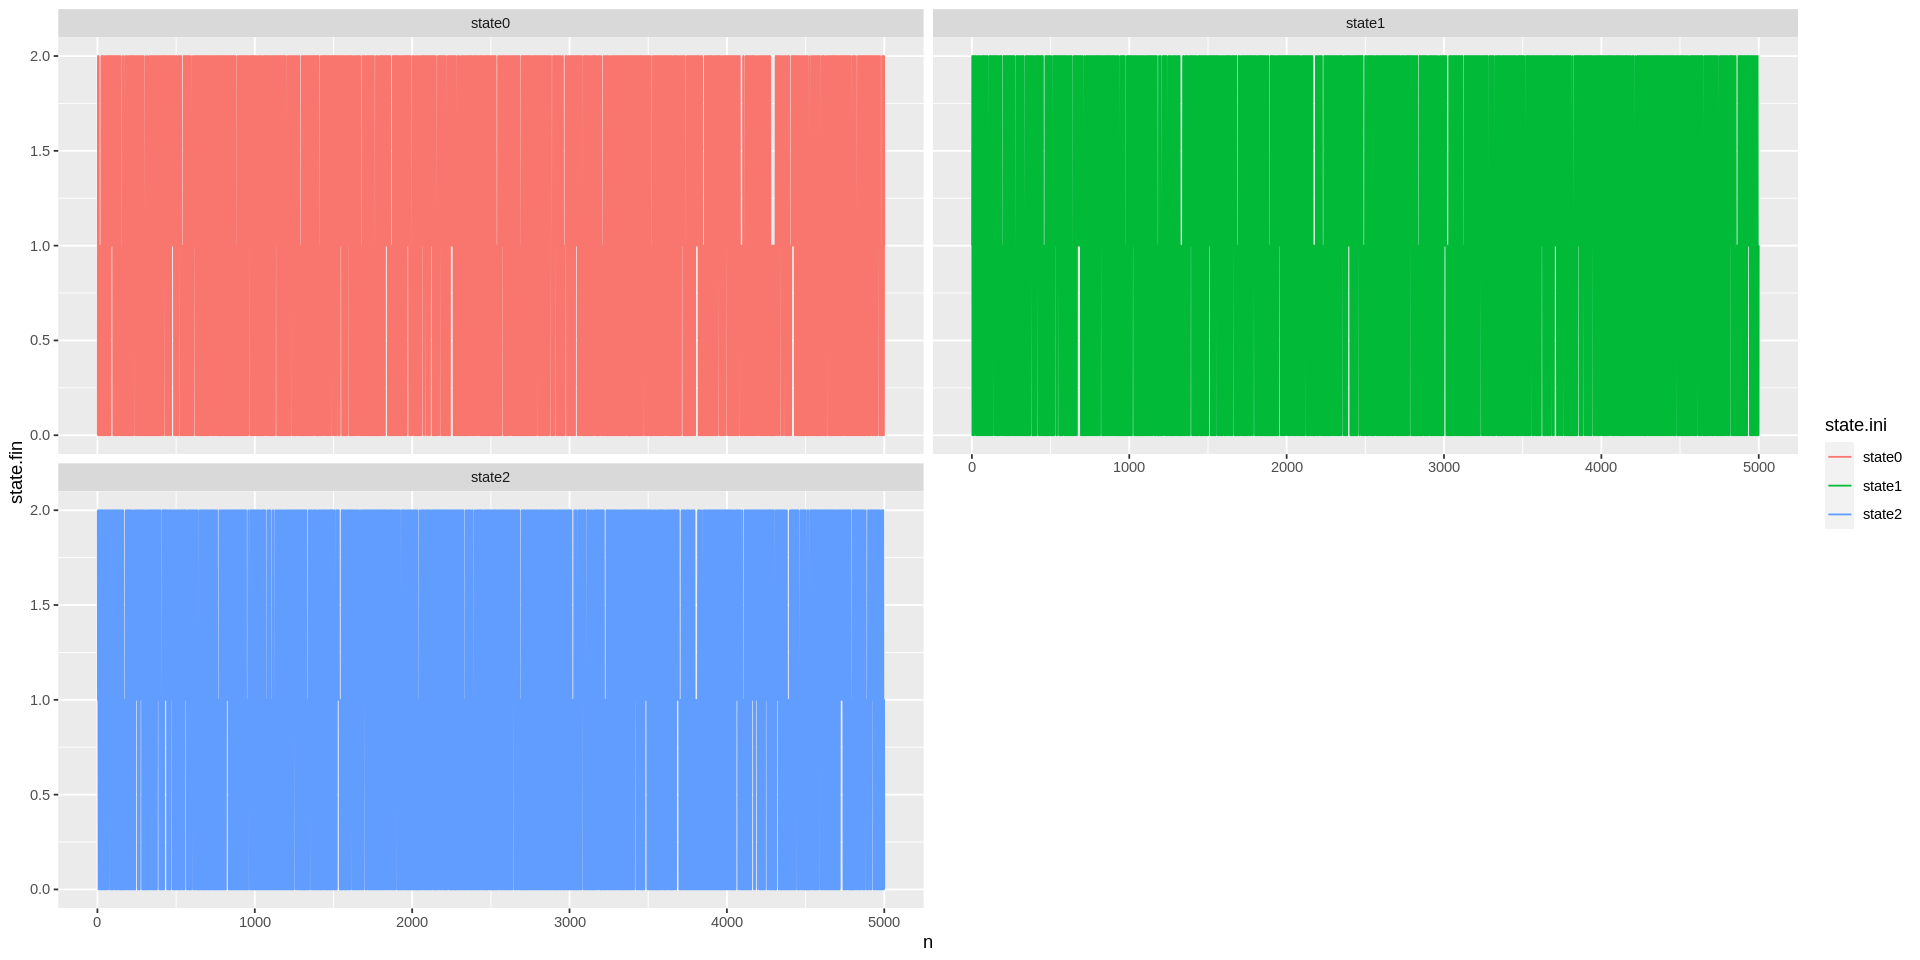

In [83]:
# plot
p2 <- ggplot(cm_n, aes(x=n, y=state.fin, col=state.ini)) +
  geom_line() +
  facet_wrap(~state.ini, nrow = 2)
p2

## Toerema ergódico

Si una cadena es irreducible y recurrente, entonces se cumple que

\begin{equation}
\lim_{n \rightarrow \infty} \frac{1}{n} N_{ij}(n) = \frac{1}{\mu_j}   , c.s.
\end{equation}

donde
- $N_{ij}(n)$ : Número de veces que la cadena pasa por el estado $j$ partiendo del estado $i$ al tiempo $n$.
- $\mu_j$ : Tiempo medio de recurrecncia del estado $j$. 

In [84]:
# Número 
cm_n %>% 
  group_by(state.ini, state.fin) %>%
  summarise('n'=n())%>%
  mutate('total'=sum(n),
         'Prop' = n/total) %>%
  select(-n, -total) %>%
  pivot_wider(names_from='state.fin', values_from='Prop', values_fill = 0)

`summarise()` has grouped output by 'state.ini'. You can override using the
`.groups` argument.


state.ini,0,1,2
<chr>,<dbl>,<dbl>,<dbl>
state0,0.2722,0.4286,0.2992
state1,0.2710,0.4208,0.3082
state2,0.2776,0.4208,0.3016


Por lo que 

$$\frac{1}{\mu_0} = 0.2722, \ \frac{1}{\mu_1} = 0.4208, \ \frac{1}{\mu_2} = 0.3016$$

In [85]:
#  Tiempos medios de recurrencia
cm_n %>% 
  group_by(state.ini, state.fin) %>%
  summarise('n'=n())%>%
  mutate('total'=sum(n),
         'Prop' = total/n) %>%
  select(-n, -total) %>%
  pivot_wider(names_from='state.fin', values_from='Prop', values_fill = 0)

`summarise()` has grouped output by 'state.ini'. You can override using the
`.groups` argument.


state.ini,0,1,2
<chr>,<dbl>,<dbl>,<dbl>
state0,3.673769,2.333178,3.342246
state1,3.690037,2.376426,3.244646
state2,3.602305,2.376426,3.315650


- $\mu_0 = 3.66$ :  representa el promedio de pasos que le toma a la cadena regresar al estado cero, partiendo del estado cero.
- $\mu_1=2.37$ : 
- $\mu_3=3.31$ : 

# Empleando paqueteria en R

In [87]:
#install.packages('markovchain')
library('markovchain')

In [89]:
mc <- new("markovchain", transitionMatrix = P, 
          states = c("Down", "None", "Up"),
          name = "Weather")

mc

Weather 
 A  3 - dimensional discrete Markov Chain defined by the following states: 
 Down, None, Up 
 The transition matrix  (by rows)  is defined as follows: 
     Down None   Up
Down 0.23 0.45 0.32
None 0.34 0.39 0.27
Up   0.20 0.47 0.33


In [90]:
# tiempo medio de recurrencia
meanRecurrenceTime(mc)

Down     None       Up 
3.727466 2.324408 3.316704

In [91]:
# periodo 
period(mc)

[1] 1

In [92]:
# clases de comunicación
communicatingClasses(mc)

[[1]]
[1] "Down" "None" "Up"

In [93]:
recurrentClasses(mc)

[[1]]
[1] "Down" "None" "Up"

In [96]:
transientStates(mc)
recurrentStates(mc)



character(0)

[1] "Down" "None" "Up"